In [3]:
import pandas as pd
import numpy as np
import tokenize_uk
import pickle

from tqdm import tqdm

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from tensorflow.python.keras.backend import set_session
import tensorflow as tf
from keras.models import Model, Input, load_model
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from seqeval.metrics import f1_score, classification_report
from ner_nlp_extracting_service import ner_nlp_extracting
from pymongo import MongoClient
from vesum_db import vesum_service
import tensorflowjs as tfjs

import os

import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [2]:
vesum_service.init_vesum()

In [3]:
with open('data_prepared/labeled_sentences.pkl', 'rb') as f:
    data = pickle.load(f)

In [5]:
class Vesum_interface():
        
    MONGO_URL = ('VESUM_MONGO_DB_URL' in os.environ and os.environ['VESUM_MONGO_DB_URL']) or 'localhost:27017'
    DB_NAME = ('VESUM_DB_NAME' in os.environ and os.environ['VESUM_DB_NAME']) or 'natasha-uk-database'
    client = MongoClient(MONGO_URL, maxPoolSize=20)
    
    
    def get_main_form_from_vesum(self, word):
        samples = [doc['mainForm'] for doc in (self.client[self.DB_NAME]['vesum-entry'].find({'word': word}))]
        if len(set(samples)) == 1:
            return samples[0]
        else:
            return word
        
vesum = Vesum_interface()        

In [4]:
%%time


words = list()

[[words.append(vesum.get_main_form_from_vesum(word[0])) for word in sentence] for sentence in tqdm(data)]

print(len(words))
words = list(set(words))
words.append("ENDPAD")
words.append("UNKNOWN")
print(len(words))

100%|██████████| 22942/22942 [06:56<00:00, 55.04it/s] 


459969
30902
CPU times: user 4min 50s, sys: 21.4 s, total: 5min 11s
Wall time: 6min 56s


In [8]:
word_embedding = dict()

with open('fiction.cased.tokenized.word2vec.300d', 'r') as f:
    next(f)
    for line in tqdm(f.readlines()):
        word, value = line.split()[0], np.asarray(line.split()[1:], dtype='float32')
        word_embedding[word] = value

100%|██████████| 116803/116803 [00:24<00:00, 4812.22it/s]


In [9]:
tags = list()

[[tags.append(word[1]) for word in sentence] for sentence in data]

print(len(tags))
tags = list(set(tags))
print(len(tags))

459969
9


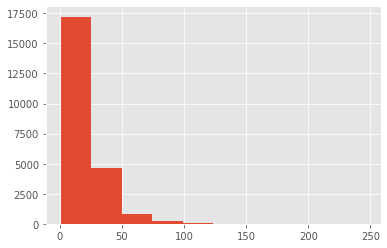

In [10]:
plt.hist([len(s) for s in data], bins=10)
plt.show()

In [64]:
# without replacement word to mainform - 50K unique words
"""
words = list()

[[words.append(word[0]) for word in sentence] for sentence in tqdm(data)]

print(len(words))
words = list(set(words))
words.append("ENDPAD")
print(len(words))
"""



  0%|          | 0/22942 [00:00<?, ?it/s]

100%|██████████| 22942/22942 [00:00<00:00, 139889.40it/s]


459969
50366


In [11]:
len(list(filter(lambda x: len(x) >= 70, data)))

381

In [12]:
word2indx = {w: i for i, w in enumerate(words)}
tag2indx = {t: i for i, t in enumerate(tags)}

In [13]:
embedding_matrix = np.zeros((len(word2indx), 300))

for word, i in tqdm(word2indx.items()):
    embedding_vector = word_embedding.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 30903/30903 [00:00<00:00, 197279.80it/s]


In [14]:
#15 455 - word without embedding vector (30K all words)
sum(list(map(lambda x: np.array_equal(x.reshape((1, 300)), np.zeros((1, 300))) , embedding_matrix)))

15456

In [9]:
X = [[word2indx[vesum.get_main_form_from_vesum(w[0])] for w in s] for s in tqdm(data)]
X = pad_sequences(X, maxlen=70, padding='post', truncating='post', value=word2indx['ENDPAD'])

100%|██████████| 22942/22942 [09:36<00:00, 39.78it/s] 


In [18]:
X[12]

array([11129, 26288,  2352, 30231, 16585, 26156, 24353, 11706, 26288,
       21131, 11292,  4965, 18777, 23888, 29182, 26288,  2026, 11370,
       24677, 27959, 26288, 21764, 14179, 24353, 16543, 30463, 15058,
       17427, 27885, 30901, 30901, 30901, 30901, 30901, 30901, 30901,
       30901, 30901, 30901, 30901, 30901, 30901, 30901, 30901, 30901,
       30901, 30901, 30901, 30901, 30901, 30901, 30901, 30901, 30901,
       30901, 30901, 30901, 30901, 30901, 30901, 30901, 30901, 30901,
       30901, 30901, 30901, 30901, 30901, 30901, 30901], dtype=int32)

In [14]:
y = [[tag2indx[w[1]] for w in s] for s in data]

y = pad_sequences(y, maxlen=70, padding="post", truncating='post', value=tag2indx["O"])

In [18]:
y[13]

array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 8, 6, 6, 6, 4, 5, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6], dtype=int32)

In [19]:
y = [to_categorical(i, num_classes=len(tag2indx)) for i in y]

In [20]:
y[12]

array([[0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [22]:
print(X_train.shape, np.array(y_train).shape)

print(X_test.shape, np.array(y_test).shape)

(20647, 70) (20647, 70, 9)
(2295, 70) (2295, 70, 9)


In [23]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [96]:
input = Input(shape=(70, ))

model = Embedding(input_dim=len(word2indx), output_dim=50, input_length=70, 
                  #embeddings_initializer=Constant(embedding_matrix),  
                  #trainable=False
                 )(input)
model = Dropout(0.1)(model)
model = Bidirectional(LSTM(units=32, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(len(tag2indx), activation="softmax"))(model)  # softmax output layer

model = Model(input, out)

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


model.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 70)                0         
_________________________________________________________________
embedding_14 (Embedding)     (None, 70, 50)            1545150   
_________________________________________________________________
dropout_6 (Dropout)          (None, 70, 50)            0         
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 70, 64)            21248     
_________________________________________________________________
time_distributed_13 (TimeDis (None, 70, 9)             585       
Total params: 1,566,983
Trainable params: 1,566,983
Non-trainable params: 0
_________________________________________________________________


In [97]:
history = model.fit(X_train, np.array(y_train), batch_size=64, epochs=20, validation_split=0.1, verbose=1, use_multiprocessing=True)

Train on 18582 samples, validate on 2065 samples
Epoch 1/20
18582/18582 [==============================] - 50s 3ms/step - loss: 0.2122 - accuracy: 0.9829 - val_loss: 0.0756 - val_accuracy: 0.9862
Epoch 2/20
18582/18582 [==============================] - 45s 2ms/step - loss: 0.0569 - accuracy: 0.9873 - val_loss: 0.0506 - val_accuracy: 0.9873
Epoch 3/20
18582/18582 [==============================] - 45s 2ms/step - loss: 0.0376 - accuracy: 0.9899 - val_loss: 0.0402 - val_accuracy: 0.9893
Epoch 4/20
18582/18582 [==============================] - 44s 2ms/step - loss: 0.0296 - accuracy: 0.9913 - val_loss: 0.0353 - val_accuracy: 0.9899
Epoch 5/20
18582/18582 [==============================] - 46s 2ms/step - loss: 0.0243 - accuracy: 0.9924 - val_loss: 0.0317 - val_accuracy: 0.9917
Epoch 6/20
18582/18582 [==============================] - 45s 2ms/step - loss: 0.0195 - accuracy: 0.9942 - val_loss: 0.0278 - val_accuracy: 0.9932
Epoch 7/20
18582/18582 [==============================] - 45s 2ms/ste

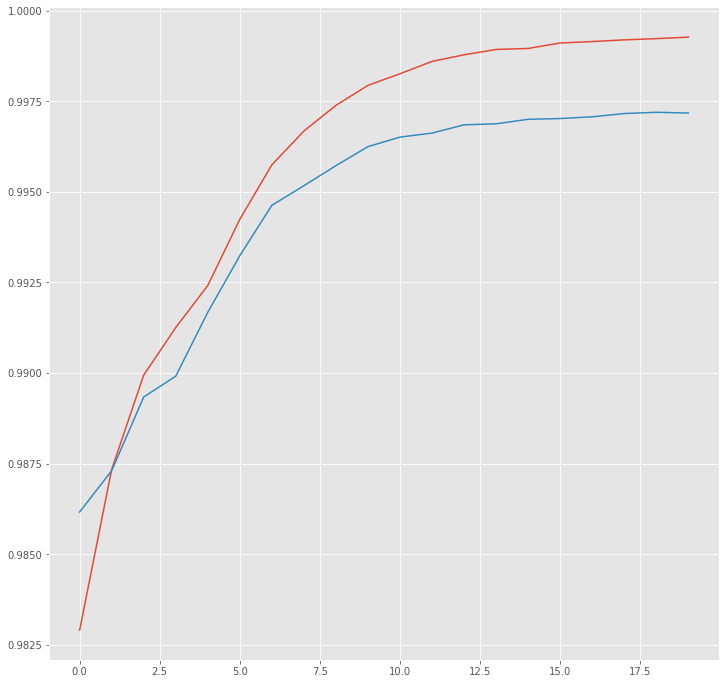

In [98]:
hist = pd.DataFrame(history.history)

plt.figure(figsize=(12,12))
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.show()

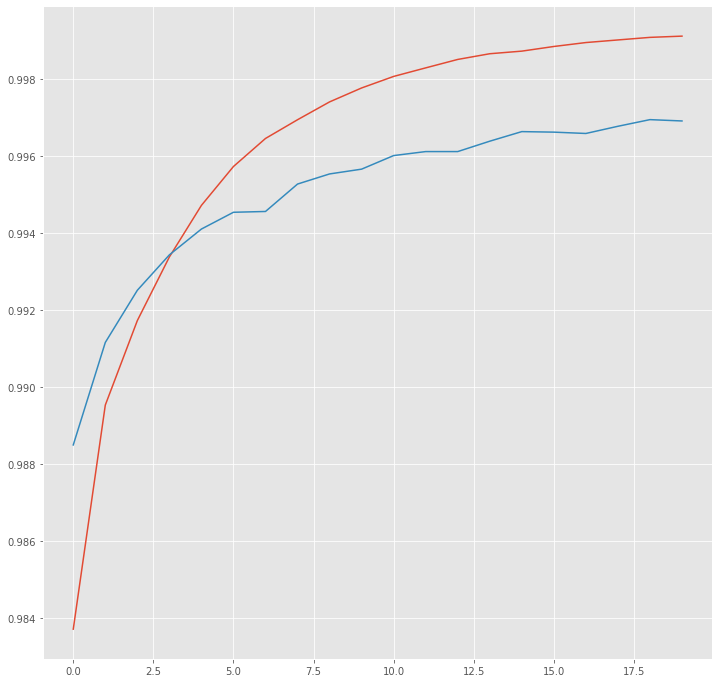

In [104]:
hist = pd.DataFrame(history.history)

plt.figure(figsize=(12,12))
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.show()

In [28]:
# lower case
print(f'Train f-score: {f1_score(y_true=[[tags[w] for w in sent] for sent in np.argmax(y_train, axis=-1)], y_pred=[[tags[w] for w in sent] for sent in np.argmax(model.predict(X_train, verbose=1), axis=-1)])}')

print(f'Test f-score: {f1_score(y_true=[[tags[w] for w in sent] for sent in np.argmax(y_test, axis=-1)], y_pred=[[tags[w] for w in sent] for sent in np.argmax(model.predict(X_test, verbose=1), axis=-1)])}')


print(classification_report(y_true=[[tags[w] for w in sent] for sent in np.argmax(y_test, axis=-1)], y_pred=[[tags[w] for w in sent] for sent in np.argmax(model.predict(X_test, verbose=1), axis=-1)]))

20647/20647 [==============================] - 25s 1ms/step
Train f-score: 0.9528867431100382
2295/2295 [==============================] - 2s 998us/step
Test f-score: 0.8043715846994536
2295/2295 [==============================] - 2s 1ms/step
           precision    recall  f1-score   support

     PERS       0.85      0.85      0.85       805
      LOC       0.76      0.82      0.79       290
     MISC       0.68      0.77      0.72       115
      ORG       0.58      0.73      0.65       129

micro avg       0.79      0.82      0.80      1339
macro avg       0.79      0.82      0.81      1339



In [30]:
# less units in lstm

print(f'Train f-score: {f1_score(y_true=[[tags[w] for w in sent] for sent in np.argmax(y_train, axis=-1)], y_pred=[[tags[w] for w in sent] for sent in np.argmax(model.predict(X_train, verbose=1), axis=-1)])}')

print(f'Test f-score: {f1_score(y_true=[[tags[w] for w in sent] for sent in np.argmax(y_test, axis=-1)], y_pred=[[tags[w] for w in sent] for sent in np.argmax(model.predict(X_test, verbose=1), axis=-1)])}')


print(classification_report(y_true=[[tags[w] for w in sent] for sent in np.argmax(y_test, axis=-1)], y_pred=[[tags[w] for w in sent] for sent in np.argmax(model.predict(X_test, verbose=1), axis=-1)]))

20647/20647 [==============================] - 17s 804us/step
Train f-score: 0.9138082673702727
2295/2295 [==============================] - 2s 773us/step
Test f-score: 0.754653130287648
2295/2295 [==============================] - 3s 1ms/step
           precision    recall  f1-score   support

      ORG       0.48      0.60      0.53       136
     PERS       0.78      0.87      0.83       819
      LOC       0.68      0.81      0.74       327
     MISC       0.59      0.48      0.53       111

micro avg       0.71      0.80      0.75      1393
macro avg       0.71      0.80      0.75      1393



In [43]:
# add f1-score in metrics, 64 batch-size
print(f'Train f-score: {f1_score(y_true=[[tags[w] for w in sent] for sent in np.argmax(y_train, axis=-1)], y_pred=[[tags[w] for w in sent] for sent in np.argmax(model.predict(X_train, verbose=1), axis=-1)])}')

print(f'Test f-score: {f1_score(y_true=[[tags[w] for w in sent] for sent in np.argmax(y_test, axis=-1)], y_pred=[[tags[w] for w in sent] for sent in np.argmax(model.predict(X_test, verbose=1), axis=-1)])}')


print(classification_report(y_true=[[tags[w] for w in sent] for sent in np.argmax(y_test, axis=-1)], y_pred=[[tags[w] for w in sent] for sent in np.argmax(model.predict(X_test, verbose=1), axis=-1)]))

20647/20647 [==============================] - 23s 1ms/step
Train f-score: 0.9458044773715574
2295/2295 [==============================] - 3s 1ms/step
Test f-score: 0.8180535966149507
2295/2295 [==============================] - 2s 1ms/step
           precision    recall  f1-score   support

      ORG       0.62      0.71      0.66       136
     PERS       0.84      0.87      0.86       819
      LOC       0.82      0.85      0.83       327
     MISC       0.72      0.64      0.68       111

micro avg       0.80      0.83      0.82      1393
macro avg       0.81      0.83      0.82      1393



In [107]:
# with main form of words, LSTM(units=32), batch_size=64
print(f'Train f-score: {f1_score(y_true=[[tags[w] for w in sent] for sent in np.argmax(y_train, axis=-1)], y_pred=[[tags[w] for w in sent] for sent in np.argmax(model.predict(X_train, verbose=1), axis=-1)])}')

print(f'Test f-score: {f1_score(y_true=[[tags[w] for w in sent] for sent in np.argmax(y_test, axis=-1)], y_pred=[[tags[w] for w in sent] for sent in np.argmax(model.predict(X_test, verbose=1), axis=-1)])}')


print(classification_report(y_true=[[tags[w] for w in sent] for sent in np.argmax(y_test, axis=-1)], y_pred=[[tags[w] for w in sent] for sent in np.argmax(model.predict(X_test, verbose=1), axis=-1)]))

20647/20647 [==============================] - 15s 724us/step
Train f-score: 0.9495199011912825
2295/2295 [==============================] - 1s 649us/step
Test f-score: 0.8376188798872842
2295/2295 [==============================] - 2s 695us/step
           precision    recall  f1-score   support

      ORG       0.63      0.69      0.66       133
     PERS       0.84      0.91      0.87       800
     MISC       0.72      0.76      0.74       126
      LOC       0.85      0.89      0.87       307

micro avg       0.81      0.87      0.84      1366
macro avg       0.81      0.87      0.84      1366



In [187]:
# with main form of words, LSTM(units=32), batch_size=64, embedding(non-trainable)
print(f'Train f-score: {f1_score(y_true=[[tags[w] for w in sent] for sent in np.argmax(y_train, axis=-1)], y_pred=[[tags[w] for w in sent] for sent in np.argmax(model.predict(X_train, verbose=1), axis=-1)])}')

print(f'Test f-score: {f1_score(y_true=[[tags[w] for w in sent] for sent in np.argmax(y_test, axis=-1)], y_pred=[[tags[w] for w in sent] for sent in np.argmax(model.predict(X_test, verbose=1), axis=-1)])}')


print(classification_report(y_true=[[tags[w] for w in sent] for sent in np.argmax(y_test, axis=-1)], y_pred=[[tags[w] for w in sent] for sent in np.argmax(model.predict(X_test, verbose=1), axis=-1)]))

20647/20647 [==============================] - 37s 2ms/step
Train f-score: 0.610128509380737
2295/2295 [==============================] - 2s 1ms/step
Test f-score: 0.5008278145695365
2295/2295 [==============================] - 2s 1ms/step
           precision    recall  f1-score   support

      ORG       0.14      0.11      0.13       133
     PERS       0.68      0.54      0.60       800
     MISC       0.22      0.12      0.15       126
      LOC       0.59      0.47      0.52       307

micro avg       0.58      0.44      0.50      1366
macro avg       0.57      0.44      0.50      1366



In [65]:
# CRF, embedding=20, batch=32
print(f'Train f-score: {f1_score(y_true=[[tags[w] for w in sent] for sent in np.argmax(y_train, axis=-1)], y_pred=[[tags[w] for w in sent] for sent in np.argmax(model.predict(X_train, verbose=1), axis=-1)])}')

print(f'Test f-score: {f1_score(y_true=[[tags[w] for w in sent] for sent in np.argmax(y_test, axis=-1)], y_pred=[[tags[w] for w in sent] for sent in np.argmax(model.predict(X_test, verbose=1), axis=-1)])}')


print(classification_report(y_true=[[tags[w] for w in sent] for sent in np.argmax(y_test, axis=-1)], y_pred=[[tags[w] for w in sent] for sent in np.argmax(model.predict(X_test, verbose=1), axis=-1)]))

20647/20647 [==============================] - 21s 1ms/step
Train f-score: 0.5538571769763555
2295/2295 [==============================] - 2s 977us/step
Test f-score: 0.5097357440890126
2295/2295 [==============================] - 2s 905us/step
           precision    recall  f1-score   support

      LOC       0.00      0.00      0.00       281
     PERS       0.50      0.85      0.63       846
      ORG       0.27      0.09      0.13       149
     MISC       0.00      0.00      0.00       103

micro avg       0.49      0.53      0.51      1379
macro avg       0.33      0.53      0.40      1379



In [39]:
# without embedding, batch=64


print(f'Train f-score: {f1_score(y_true=[[tags[w] for w in sent] for sent in np.argmax(y_train, axis=-1)], y_pred=[[tags[w] for w in sent] for sent in np.argmax(model.predict(X_train.reshape((X_train.shape[0], X_train.shape[1], 1)), verbose=1), axis=-1)])}')

print(f'Test f-score: {f1_score(y_true=[[tags[w] for w in sent] for sent in np.argmax(y_test, axis=-1)], y_pred=[[tags[w] for w in sent] for sent in np.argmax(model.predict(X_test.reshape((X_test.shape[0], X_test.shape[1], 1)), verbose=1), axis=-1)])}')


print(classification_report(y_true=[[tags[w] for w in sent] for sent in np.argmax(y_test, axis=-1)], y_pred=[[tags[w] for w in sent] for sent in np.argmax(model.predict(X_test.reshape((X_test.shape[0], X_test.shape[1], 1)), verbose=1), axis=-1)]))

20647/20647 [==============================] - 12s 585us/step
Train f-score: 0
2295/2295 [==============================] - 2s 666us/step
Test f-score: 0
2295/2295 [==============================] - 1s 586us/step
           precision    recall  f1-score   support

     PERS       0.00      0.00      0.00       778
      LOC       0.00      0.00      0.00       288
      ORG       0.00      0.00      0.00       147
     MISC       0.00      0.00      0.00       108

micro avg       0.00      0.00      0.00      1321
macro avg       0.00      0.00      0.00      1321



In [68]:
# embedding=5, lstm=4, batch=64, epochs=15


print(f'Train f-score: {f1_score(y_true=[[tags[w] for w in sent] for sent in np.argmax(y_train, axis=-1)], y_pred=[[tags[w] for w in sent] for sent in np.argmax(model.predict(X_train, verbose=1), axis=-1)])}')

print(f'Test f-score: {f1_score(y_true=[[tags[w] for w in sent] for sent in np.argmax(y_test, axis=-1)], y_pred=[[tags[w] for w in sent] for sent in np.argmax(model.predict(X_test, verbose=1), axis=-1)])}')


print(classification_report(y_true=[[tags[w] for w in sent] for sent in np.argmax(y_test, axis=-1)], y_pred=[[tags[w] for w in sent] for sent in np.argmax(model.predict(X_test, verbose=1), axis=-1)]))

20647/20647 [==============================] - 10s 465us/step
Train f-score: 0.5721529015646662
2295/2295 [==============================] - 1s 451us/step
Test f-score: 0.5598105013817608
2295/2295 [==============================] - 1s 462us/step
           precision    recall  f1-score   support

     PERS       0.65      0.81      0.72       778
      LOC       0.42      0.21      0.28       288
      ORG       0.21      0.13      0.16       147
     MISC       0.00      0.00      0.00       108

micro avg       0.58      0.54      0.56      1321
macro avg       0.50      0.54      0.50      1321



In [78]:
# embedding=50, lstm=32, batch=64, epochs=15, add dropout


print(f'Train f-score: {f1_score(y_true=[[tags[w] for w in sent] for sent in np.argmax(y_train, axis=-1)], y_pred=[[tags[w] for w in sent] for sent in np.argmax(model.predict(X_train, verbose=1), axis=-1)])}')

print(f'Test f-score: {f1_score(y_true=[[tags[w] for w in sent] for sent in np.argmax(y_test, axis=-1)], y_pred=[[tags[w] for w in sent] for sent in np.argmax(model.predict(X_test, verbose=1), axis=-1)])}')


print(classification_report(y_true=[[tags[w] for w in sent] for sent in np.argmax(y_test, axis=-1)], y_pred=[[tags[w] for w in sent] for sent in np.argmax(model.predict(X_test, verbose=1), axis=-1)]))

20647/20647 [==============================] - 14s 661us/step
Train f-score: 0.95485778203899
2295/2295 [==============================] - 2s 699us/step
Test f-score: 0.8894941634241245
2295/2295 [==============================] - 2s 669us/step
           precision    recall  f1-score   support

     PERS       0.93      0.91      0.92       778
      LOC       0.91      0.87      0.89       288
      ORG       0.90      0.76      0.83       147
     MISC       0.82      0.69      0.75       108

micro avg       0.92      0.87      0.89      1321
macro avg       0.91      0.87      0.89      1321



In [100]:
# embedding=50, lstm=32, batch=64, epochs=15, add dropout


print(f'Train f-score: {f1_score(y_true=[[tags[w] for w in sent] for sent in np.argmax(y_train, axis=-1)], y_pred=[[tags[w] for w in sent] for sent in np.argmax(model.predict(X_train, verbose=1), axis=-1)])}')

print(f'Test f-score: {f1_score(y_true=[[tags[w] for w in sent] for sent in np.argmax(y_test, axis=-1)], y_pred=[[tags[w] for w in sent] for sent in np.argmax(model.predict(X_test, verbose=1), axis=-1)])}')


print(classification_report(y_true=[[tags[w] for w in sent] for sent in np.argmax(y_test, axis=-1)], y_pred=[[tags[w] for w in sent] for sent in np.argmax(model.predict(X_test, verbose=1), axis=-1)]))

20647/20647 [==============================] - 18s 882us/step
Train f-score: 0.9574493683577301
2295/2295 [==============================] - 2s 788us/step
Test f-score: 0.8879377431906614
2295/2295 [==============================] - 2s 778us/step
           precision    recall  f1-score   support

     PERS       0.93      0.91      0.92       778
      LOC       0.90      0.84      0.87       288
      ORG       0.86      0.78      0.82       147
     MISC       0.90      0.69      0.78       108

micro avg       0.91      0.86      0.89      1321
macro avg       0.91      0.86      0.89      1321



In [110]:
model.save('saved_objects/model_without_pretrained_embedding.h5')

In [129]:
with open('saved_objects/word2indx', 'wb') as f:
    pickle.dump(word2indx, f)
    
    
with open('saved_objects/tag2indx', 'wb') as f:
    pickle.dump(tag2indx, f)    

In [6]:
vesum_service.init_vesum()

sess = tf.Session()

graph = tf.get_default_graph()

set_session(sess)

model = load_model('saved_objects/model_without_pretrained_embedding.h5')

vesum = Vesum_interface()
    

with open('saved_objects/word2indx', 'rb') as f:
    word2indx = pickle.load(f)
    
with open('saved_objects/tag2indx', 'rb') as f:
    tag2indx = pickle.load(f)  

In [7]:
ner_nlp_extracting('біографія Івана Кузьменка досить цікава',
                   model, vesum, word2indx, tag2indx, sess, graph)

[{'entity_type': 'PERS',
  'start_index': 10,
  'finish_index': 25,
  'text_entity': 'Івана Кузьменка'}]

## Save objects to json

In [9]:
import json

In [8]:
tfjs.converters.save_keras_model(model, 'saved_objects/model_without_pretrained_embedding_js.json')

/home/valentyn/NER_UA/venv/lib/python3.6/site-packages/tensorflowjs/converters/keras_h5_conversion.py:122: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  return h5py.File(h5file)


In [13]:
with open('saved_objects/word2indx_js.json', 'w') as fp:
    json.dump(word2indx, fp)

In [14]:
with open('saved_objects/tag2indx_js.json', 'w') as fp:
    json.dump(tag2indx, fp)